<a target="_blank" href="https://colab.research.google.com/github/umanitoba-meagher-projects/public-experiments/blob/main/jupyter-notebooks/Visualize%20Image%20Information/tree-map.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [ ]:
"""
Author: Ryleigh J. Bruce
Date: June 10, 2024

Purpose: To generate a treemap to compare the volume of sightings across animal species and seasons


Note: The author generated this text in part with GPT-4,
OpenAI’s large-scale language-generation model. Upon generating
draft code, the authors reviewed, edited, and revised the code
to their own liking and takes ultimate responsibility for
the content of this code.

"""

## Introduction

This Jupyter Notebook is designed to generate treemaps that visualize the volume of animal sightings across different species and seasons. The notebook begins by importing and preparing the necessary libraries and datasets, followed by data manipulation to group and summarize the information. It then creates treemaps to represent the data visually, both as a single comprehensive treemap and as individual treemaps for each season. The methodology involves using Python libraries such as `pandas` for data manipulation, `matplotlib` for visualization, and `squarify` for treemap generation. The notebook also includes functionality to filter data by location and season, normalize sizes for visualization, and assign unique colors to species for clarity. Additionally, it provides a legend for better interpretability and adjusts plot dimensions dynamically based on the dataset. This notebook is beneficial for analyzing patterns in animal sightings, understanding seasonal variations, and presenting data in an accessible visual format. It is structured to be modular, allowing users to adapt it for different datasets or purposes, making it a versatile tool for data exploration and visualization.


## Critical Uses & Adaptability

### What the Notebook Can Be Used For:

- **Dataset Exploration:**  
  This notebook provides a structured approach to exploring datasets by grouping, summarizing, and visualizing data. It is particularly useful for identifying patterns, trends, and outliers in animal sightings across species and seasons.

- **Educational Purposes & Demonstrations:**  
  The notebook serves as an educational resource for demonstrating the use of Python in data analysis and visualization. It introduces readers to libraries like `pandas`, `matplotlib`, and `squarify`, and showcases how machine learning-adjacent techniques can be applied to work with image-related datasets.

- **Feature Extraction:**  
  By grouping data and visualizing it in treemaps, the notebook aids in extracting key features such as the most frequently sighted species or seasonal trends. These insights can be used for further analysis or decision-making.

### How the Notebook Can Be Adapted:

- **Integration with Spatial Design & Architectural Studies:**  
  The notebook can be adapted for site analysis in spatial design and architecture by replacing the dataset with location-based data. For example, it could visualize the distribution of vegetation, wildlife, or human activity across a site.

- **Variables & Customization:**  
  - The notebook's variables, such as `location_id` and `Season`, can be modified to focus on specific subsets of data.  
  - Users can adjust the figure size, color schemes, and normalization parameters in the plotting sections (e.g., `squarify.plot()`) to suit their visualization needs.

- **Swapping Datasets:**  
  - The dataset can be replaced by modifying the file path in the cell that loads the data for single or seasonal treemaps.  
  - Users can adapt the notebook to work with different datasets, such as those containing image metadata, by ensuring the new dataset has compatible columns or adjusting the code accordingly.

- **Scalability:**  
  The notebook is scalable for larger datasets or more complex analyses. For instance, additional grouping criteria can be added to the `groupby()` function, or the visualization can be extended to include interactive plots using libraries like `plotly`.

## Module: Borealis Data Repository Integration

This module sets up the Borealis Data Repository API functions needed to download the animal sightings dataset. The code defines functions to get dataset information, download files, and handle zip file extraction. The Borealis API allows programmatic access to research datasets without requiring authentication for public datasets. The data is hosted in the University of Manitoba Dataverse (https://borealisdata.ca/dataverse/manitoba), a research data repository. The images used in this notebook were collected as part of the 'Understanding Animals' project at University of Manitoba Faculty of Architecture, online at Wild Winnipeg and Teaching with Images.

In [1]:
# Borealis API configuration
import requests
import zipfile

BOREALIS_SERVER = "https://borealisdata.ca"

def get_public_dataset_info(persistent_id):
    """
    Get information about a public dataset
    """
    url = f"{BOREALIS_SERVER}/api/datasets/:persistentId/"
    params = {"persistentId": persistent_id}

    response = requests.get(url, params=params)

    if response.status_code == 200:
        dataset_info = response.json()
    else:
        print(f"Cannot access dataset: {response.status_code}")
        return None
    """
    Get a list of files in a public dataset
    """
    # Access the list of files from the dataset_info dictionary
    files_list = dataset_info['data']['latestVersion']['files']

    # Create an empty list to store file information
    file_info_list = []

    # Iterate through the files list and append file ID and filename to the list
    for file_info in files_list:
        file_id = file_info['dataFile']['id']
        filename = file_info['dataFile']['filename']
        file_info_list.append({"file_id": file_id, "filename": filename})

    return file_info_list

def download_public_file(file_id, save_path="./"):
    """
    Download a specific public file from a dataset by its file ID
    No authentication required
    """
    url = f"{BOREALIS_SERVER}/api/access/datafile/{file_id}"

    response = requests.get(url, stream=True)

    if response.status_code == 200:
        # Determine filename from headers or URL
        filename = None
        if "Content-Disposition" in response.headers:
            cd = response.headers["Content-Disposition"]
            # Try to extract filename from content disposition
            if "filename=" in cd:
                filename = cd.split("filename=")[1].strip('"')

        # Fallback to extracting from URL if header not available or malformed
        if not filename:
             filename = url.split("/")[-1]

        file_path = f"{save_path}/{filename}"

        with open(file_path, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)

        print(f"SUCCESS: File downloaded to {file_path}")
        return file_path
    else:
        print(f"ERROR: {response.status_code}: File may be restricted or not found")
        return None

def is_zip_file(filepath):
    """
    Checks if a file is a valid zip file.
    """
    return zipfile.is_zipfile(filepath)

def unzip_file(filepath, extract_path="./"):
    """
    Unzips a zip file to a specified path and returns the name of the top-level extracted folder.
    Returns None if not a zip file or extraction fails.
    """
    if is_zip_file(filepath):
        try:
            with zipfile.ZipFile(filepath, 'r') as zip_ref:
                # Get the name of the top-level directory within the zip
                # Assumes there is a single top-level directory
                top_level_folder = None
                for file_info in zip_ref.infolist():
                    parts = file_info.filename.split('/')
                    if parts[0] and len(parts) > 1:
                        top_level_folder = parts[0]
                        break # Assuming the first entry gives the top-level folder

                zip_ref.extractall(extract_path)
                print(f"SUCCESS: Successfully unzipped {filepath} to {extract_path}")
                return top_level_folder

        except Exception as e:
            print(f"ERROR: Error unzipping {filepath}: {e}")
            return None
    else:
        print(f"INFO: {filepath} is not a valid zip file.")
        return None

# Initialize Borealis dataset access
public_doi = "doi:10.5683/SP3/H3HGWF"
print("Borealis dataset initialized for animal notebook data.")

Borealis dataset initialized for animal notebook data.


This module imports the `pandas`, `matplotlib`, `squarify`, and `numpy` libraries. The `pandas` library is crucial for data manipulation, and `matplotlib` is a plotting library that allows various visualizations to be created in Python. `Squarify` is a specialized library to create treemaps and `numpy` is useful for handling arrays and other aspects of numerical computing.

In [2]:
!pip install squarify
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import numpy as np

# Creating a Single Treemap

## Module: Create a DataFrame Using the Excel File

The `setup_and_load_dataset()` function first checks if the Excel file already exists locally. If not, it connects to the Borealis Data Repository using the dataset DOI, retrieves the file list, downloads the animal sightings Excel file, and loads it into a two-dimensional pandas DataFrame. This approach ensures the most current version of the dataset is used while avoiding unnecessary downloads.

In [20]:
# Load the data into a Pandas dataframe
def setup_and_load_dataset():
    """
    Download and extract the dataset from Borealis, then load the Excel file
    """
    # Check if the Excel file already exists
    if os.path.exists("./combined_animals.xlsx"):
        print("Excel file already exists, loading data...")
        return pd.read_excel("./combined_animals.xlsx")

    # Initialize Borealis dataset access
    public_doi = "doi:10.5683/SP3/H3HGWF"
    print("Getting dataset information...")

    # Get dataset file information
    file_info_list = get_public_dataset_info(public_doi)

    if not file_info_list:
        print("Failed to get dataset information.")
        return None

    print(f"Found {len(file_info_list)} files in dataset.")

    # Find and download the Excel file
    excel_file = None
    for file_info in file_info_list:
        if 'combined_animals' in file_info['filename'].lower() and file_info['filename'].endswith('.xlsx'):
            excel_file = file_info
            break

    # If no combined_animals.xlsx, look for any Excel file
    if not excel_file:
        for file_info in file_info_list:
            if file_info['filename'].endswith('.xlsx'):
                excel_file = file_info
                break

    if not excel_file:
        print("Could not find Excel file in dataset. Available files:")
        for file_info in file_info_list:
            print(f"  - {file_info['filename']}")
        return None

    print(f"Downloading {excel_file['filename']}...")
    downloaded_file = download_public_file(excel_file['file_id'])

    if not downloaded_file:
        print("Failed to download Excel file.")
        return None

    # Rename the downloaded file to the expected name
    import shutil
    if os.path.exists(downloaded_file):
        shutil.move(downloaded_file, './combined_animals.xlsx')
        print(f"Renamed downloaded file to combined_animals.xlsx")

    # Verify the file exists before loading
    if not os.path.exists('./combined_animals.xlsx'):
        print("Error: Excel file not found after download and rename.")
        return None

    # Load and return the dataframe
    print("Loading Excel file into DataFrame...")
    return pd.read_excel("./combined_animals.xlsx")
# Import os module if not already imported
import os
# Execute the setup and load function
df = setup_and_load_dataset()
if df is not None:
    print(f"Successfully loaded dataset with {len(df)} rows and {len(df.columns)} columns.")
    print(f"Columns: {list(df.columns)}")
else:
    print("Failed to load dataset. Please check your connection and try again.")

Excel file already exists, loading data...
Successfully loaded dataset with 115273 rows and 36 columns.
Columns: ['Unnamed: 0', 'newFile', 'RelativePath', 'Folder', 'Date', 'locationID', 'cameraNum', 'Time', 'ImageQuality', 'DeleteFlag', 'SpeciesCount', 'SpeciesList', 'animalFlag', 'SetupFlag', 'AdultCount', 'JuvenileCount', 'MaleFlag', 'FemaleFlag', 'AntlersFlag', 'TempC', 'MoonPhase', 'CaptureType', 'AmbientLight', 'PublishFlag', 'ActivityList', 'EpisodeStart', 'Sensitivity', 'BatteryLevel', 'Unnamed: 25', 'Unnamed: 23', 'RootFolder', 'RepresentFlag', 'DateTime', 'Unnamed: 24', 'Dark', 'Unnamed: 26']


Here the `groupby()` function is used to group the rows within the DataFrame by the values in the `SpeciesList` column. This means that all rows containing the same species name are grouped. `[“SpeciesCount”].sum` calculates the sum of all of the values within the `SpeciesCount` column for each species group. The final portion of this line, `.reset_index()`, resets the index of the DataFrame and returns the `SpeciesList` to a column from its grouped state.

In [ ]:
# Summarize the data for the treemap
species_counts = df.groupby("SpeciesList")["SpeciesCount"].sum().reset_index()

Here the DataFrame is sorted based on the values in the `SpeciesCount` column. `ascending=False` ensures that the values are sorted in descending order, to ensure that the most significant categories will be seen first.

In [ ]:
# Sort the data for better visualization
species_counts = species_counts.sort_values(by="SpeciesCount", ascending=False)

## Module: Prepare the Values to be Plotted

The `squarify.normalize_sizes()` function normalizes the size of the rectangles to be used in the treemap. The `100,100` values represent the width and height of the treemap layout.

In [ ]:
# Normalize sizes
sizes = squarify.normalize_sizes(species_counts["SpeciesCount"], 100, 100)

`num_categories = len(species_counts)` counts and returns the number of rows in the species_counts DataFrame and stores it in the `num_categories` variable. This value is then used to determine the number of unique colors that must be stored in the `colors` variable. These colors are drawn from a pre-existing colormap called `tab20c` which is called using the `plt.get_cmap() function`.

In [ ]:
# Create a colormap
num_categories = len(species_counts)
colors = plt.get_cmap('tab20c')(np.linspace(0, 1, num_categories))

## Module: Create the Figure

Here the `matplotlib` library is used to create a new figure and set of subplots. The size is specified using `figsize=(12, 8)` which means that the created figure will be 12 inches wide and 8 inches tall.

`squarify.plot()` creates the treemap plot using the normalized rectangles and the colors determined in previous modules, while the `ax=ax` and `pad=True` parameters enhance plot legibility.

In [ ]:
# Create a squarify plot
fig, ax = plt.subplots(figsize=(12, 8))
squarify.plot(sizes=sizes,
              color=colors,
              alpha=.8,
              ax=ax,
              pad=True)

This piece of code ensures that the generated graph is free of axis lines, ticks, and labels.

In [ ]:
# Hide axes
ax.axis('off')

## Module: Create a Legend and Display the Plot

The first line of code creates a list of `handles`, objects that can be used in a legend. The `handles` being created here are small rectangles of color according to the corresponding species.

The second line extracts the labels for the legend from the `species_counts` DataFrame.

In [ ]:
# Create a legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[i]) for i in range(num_categories)]
labels = species_counts["SpeciesList"]

This code anchors the bounding box to the center left of the remaining space and sets the title of the legend as ‘Species’.

In [ ]:
ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), title="Species")

To display the final plot:

In [ ]:
# Display the plot
plt.show()

#Creating a Treemap for Each Season

The required libraries are imported again to ensure they're available for the seasonal analysis. This includes `pandas` for data manipulation, `matplotlib` for plotting, `squarify` for treemap generation, and `numpy` for numerical operations.

In [ ]:
!pip install squarify
import pandas as pd
import matplotlib.pyplot as plt
import squarify
import numpy as np

The script loads the Excel file into a DataFrame using the same dataset that was downloaded and processed by the `setup_and_load_dataset()` function. This ensures consistency between the single treemap and seasonal treemap analyses.

In [ ]:
# Load the data into a Pandas dataframe
def setup_and_load_dataset():
    """
    Download and extract the dataset from Borealis, then load the Excel file
    """
    # Check if the Excel file already exists
    if os.path.exists("./combined_animals.xlsx"):
        print("Excel file already exists, loading data...")
        return pd.read_excel("./combined_animals.xlsx")

    # Initialize Borealis dataset access
    public_doi = "doi:10.5683/SP3/H3HGWF"
    print("Getting dataset information...")

    # Get dataset file information
    file_info_list = get_public_dataset_info(public_doi)

    if not file_info_list:
        print("Failed to get dataset information.")
        return None

    print(f"Found {len(file_info_list)} files in dataset.")

    # Find and download the Excel file
    excel_file = None
    for file_info in file_info_list:
        if 'combined_animals' in file_info['filename'].lower() and file_info['filename'].endswith('.xlsx'):
            excel_file = file_info
            break

    # If no combined_animals.xlsx, look for any Excel file
    if not excel_file:
        for file_info in file_info_list:
            if file_info['filename'].endswith('.xlsx'):
                excel_file = file_info
                break

    if not excel_file:
        print("Could not find Excel file in dataset. Available files:")
        for file_info in file_info_list:
            print(f"  - {file_info['filename']}")
        return None

    print(f"Downloading {excel_file['filename']}...")
    downloaded_file = download_public_file(excel_file['file_id'])

    if not downloaded_file:
        print("Failed to download Excel file.")
        return None

    # Rename the downloaded file to the expected name
    import shutil
    if os.path.exists(downloaded_file):
        shutil.move(downloaded_file, './combined_animals.xlsx')
        print(f"Renamed downloaded file to combined_animals.xlsx")

    # Verify the file exists before loading
    if not os.path.exists('./combined_animals.xlsx'):
        print("Error: Excel file not found after download and rename.")
        return None

    # Load and return the dataframe
    print("Loading Excel file into DataFrame...")
    return pd.read_excel("./combined_animals.xlsx")

# Import os module if not already imported
import os

# Execute the setup and load function
df = setup_and_load_dataset()

if df is not None:
    print(f"Successfully loaded dataset with {len(df)} rows and {len(df.columns)} columns.")
    print(f"Columns: {list(df.columns)}")
else:
    print("Failed to load dataset. Please check your connection and try again.")

The ‘Date’ column from the DataFrame is then converted into datetime format using the `pd.to_datetime function`. The script then replaces the original ‘Date’ column with the data newly converted in datetime format.

## Module: Manipulating the DataFrame

In [6]:
# Convert dates to datetime
df['Date'] = pd.to_datetime(df['Date'])

The `get_season()` function uses the month data in integer format and returns a string representing the seasons the given month falls in.

In [7]:
# Define a function to determine the season based on the month
def get_season(month):
    if month in (12, 1, 2):
        return 'Winter'
    elif month in (3, 4, 5):
        return 'Spring'
    elif month in (6, 7, 8):
        return 'Summer'
    elif month in (9, 10, 11):
        return 'Autumn'

The `df[‘Date’].dt.month` function extracts the month from the ‘Date’ column within the DataFrame and `.apply(get_season)` applies the function defined previously to convert the month data into its season, creating a new ‘Season’ column within the DataFrame to store the converted information.

In [8]:
# Apply the season function to each date
df['Season'] = df['Date'].dt.month.apply(get_season)

The DataFrame is then filtered to only include information relevant to the desired location ID (here it is location 7) with the code `df['locationID'] == location_id`. This is done by creating a Boolean series comparing the ‘locationID’ column in the DataFrame to the location_id variable. In rows where the value is the same, it will be ‘True’, and ‘False’ for all other values. The returned DataFrame is then assigned to the `df` variable for later use.

In [9]:
# Specify the locationID for filtering and title
location_id = 7
df = df[df['locationID'] == location_id]

Here a DataFrame is created called `seasonal_species_counts` by grouping the original DataFrame by the ‘Season’ and ‘SpeciesList’ columns. Rows with the same unique combination of ‘Season’ and ‘SpeciesList’ are then grouped together. The `agg` function is then used to calculate the sum for the ‘SpeciesCount’ value in each of the grouped rows.

In [10]:
# Group data by season and species and sum species counts
seasonal_species_counts = df.groupby(['Season', 'SpeciesList']).agg({'SpeciesCount': 'sum'}).reset_index()

The first line retrieves the unique species in the ‘SpeciesList’ column of the DataFrame `seasonal_species_counts` and assigns them to the variable `unique_species`.Then the get_cmpa function is used in the next line to import the ‘tab20c’ colormap in order to assign a unique color to each species. In the final line of the code block, a dictionary is created where each key is a species name from the `unique_species` variable and the value is a color from the imported colormap.

In [11]:
# Determine the maximum number of unique species across all seasons
unique_species = seasonal_species_counts['SpeciesList'].unique()
color_map = plt.get_cmap('tab20c')
colors = {species: color_map(i % color_map.N) for i, species in enumerate(unique_species)}

Here the script determines the maximum number of sightings for each season across all species and stores those values in the `max_total value`. In cases where a season is missing information, the value is automatically set to 0.

In [12]:
# Get the total of sightings in each season to scale the plots
season_totals = seasonal_species_counts.groupby('Season')['SpeciesCount'].sum().reindex(['Winter', 'Spring', 'Summer', 'Autumn'], fill_value=0)
max_total = season_totals.max()

## Module: Preparing to Plot the Treemaps

The following code blocks prepare a plot for each of the treemaps that corresponds with the volume of sightings for the given season. for season in season_totals.index iteratively processes each season stored in the season_total variable. The script then selects only the rows from seasonal_species_count where the season matches the current iteration’s season. If there is recorded information to plot, `base_size = 5` and `fig_size = base_size * (season_totals[season] / max_total)` set the size of the plot based on the total spotted species for a season. The previously assigned colors are then retrieved and the treemap is generated using the calculated sizes and colors.

`ax.set_title(f'{season} (Total Sightings: {season_totals[season]:,.0f})')` ensures that the correct season is printed for each graph, and `axis(‘off’)` removes unnecessary axis labels to increase legibility.

If there is no information recorded for a given season, the script will skip over the previous steps and simply print “No information gathered for `{season}` at Location `{location_id}`.” and continue on to the next season.

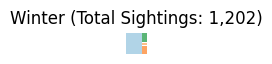

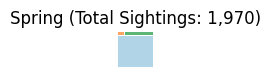

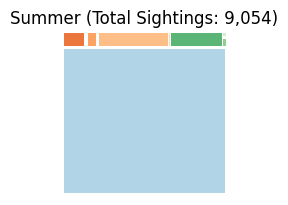

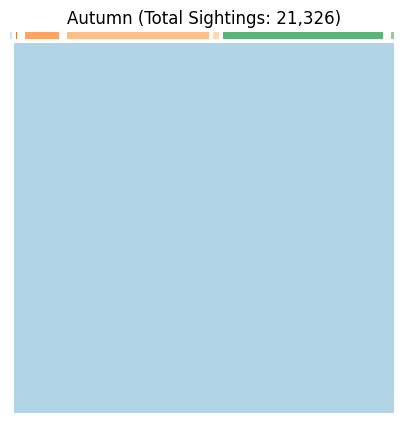

In [14]:
# Plotting
for season in season_totals.index:
    group = seasonal_species_counts[seasonal_species_counts['Season'] == season]
    if not group.empty:
        base_size = 5  # Base size for the smallest season graph
        # Scaling the figure size based on the relative volume of sightings
        fig_size = base_size * (season_totals[season] / max_total)
        fig, ax = plt.subplots(figsize=(fig_size, fig_size))

        sizes = squarify.normalize_sizes(group['SpeciesCount'], season_totals[season], season_totals[season])
        plot_colors = [colors[species] for species in group['SpeciesList']]

        squarify.plot(sizes=sizes, color=plot_colors, alpha=0.8, pad=0.5, ax=ax)
        ax.set_title(f'{season} (Total Sightings: {season_totals[season]:,.0f})')
        ax.axis('off')
    else:
        print(f"No information gathered for {season} at Location {location_id}.")

## Module: Creating the Legend and Displaying the Treemap

To ensure proper legend display, the script creates a separate figure dedicated to the legend. This approach resolves display issues that can occur when trying to attach legends to individual subplot figures. The legend uses rectangular handles that correspond to the colors assigned to each species in the `colors` dictionary. The legend figure is titled with the location ID and displays all species found across the seasonal data. This method provides a clear, standalone reference for interpreting the colors used across all seasonal treemaps.

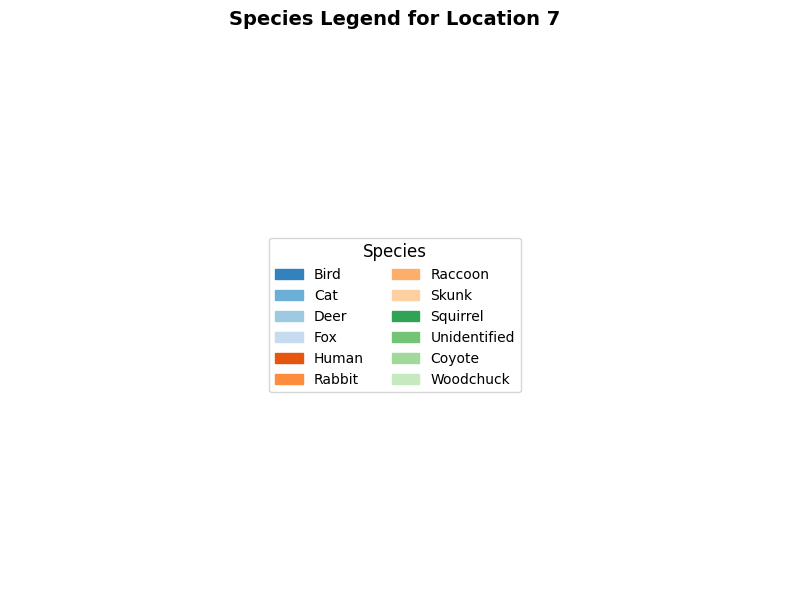

'\n# Alternative: Create all seasonal treemaps in a single figure with shared legend\nseasons = [\'Winter\', \'Spring\', \'Summer\', \'Autumn\']\nfig, axes = plt.subplots(2, 2, figsize=(16, 12))\naxes = axes.flatten()\n\nfor i, season in enumerate(seasons):\n    ax = axes[i]\n    group = seasonal_species_counts[seasonal_species_counts[\'Season\'] == season]\n    \n    if not group.empty:\n        sizes = squarify.normalize_sizes(group[\'SpeciesCount\'], 100, 100)\n        plot_colors = [colors[species] for species in group[\'SpeciesList\']]\n        \n        squarify.plot(sizes=sizes, color=plot_colors, alpha=0.8, pad=0.5, ax=ax)\n        ax.set_title(f\'{season}\n(Total Sightings: {season_totals[season]:,.0f})\', \n                     fontsize=12, fontweight=\'bold\')\n    else:\n        ax.text(0.5, 0.5, f\'No data for {season}\nat Location {location_id}\', \n                ha=\'center\', va=\'center\', fontsize=12, transform=ax.transAxes)\n    \n    ax.axis(\'off\')\n\n# Create s

In [18]:
# Create a separate figure for the legend
legend_fig, legend_ax = plt.subplots(figsize=(8, 6))

# Hide the axes for the legend figure
legend_ax.axis('off')

# Create legend handles and labels
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[species]) for species in unique_species]
labels = unique_species

# Create the legend on the legend figure
legend_ax.legend(handles, labels, loc='center', title="Species",
                 fontsize=10, title_fontsize=12, ncol=2)

# Set title for the legend figure
legend_fig.suptitle(f'Species Legend for Location {location_id}', fontsize=14, fontweight='bold')

# Display the legend
plt.tight_layout()
plt.show()

# Alternative approach: Create legend with all seasonal plots in a single figure
# Uncomment the code below if you prefer all seasons in one figure with a shared legend

"""
# Alternative: Create all seasonal treemaps in a single figure with shared legend
seasons = ['Winter', 'Spring', 'Summer', 'Autumn']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    ax = axes[i]
    group = seasonal_species_counts[seasonal_species_counts['Season'] == season]

    if not group.empty:
        sizes = squarify.normalize_sizes(group['SpeciesCount'], 100, 100)
        plot_colors = [colors[species] for species in group['SpeciesList']]

        squarify.plot(sizes=sizes, color=plot_colors, alpha=0.8, pad=0.5, ax=ax)
        ax.set_title(f'{season}\n(Total Sightings: {season_totals[season]:,.0f})',
                     fontsize=12, fontweight='bold')
    else:
        ax.text(0.5, 0.5, f'No data for {season}\nat Location {location_id}',
                ha='center', va='center', fontsize=12, transform=ax.transAxes)

    ax.axis('off')

# Create shared legend
handles = [plt.Rectangle((0, 0), 1, 1, color=colors[species]) for species in unique_species]
fig.legend(handles, unique_species, loc='center right', bbox_to_anchor=(1.15, 0.5),
           title="Species", fontsize=10, title_fontsize=12)

plt.suptitle(f'Seasonal Animal Sightings at Location {location_id}',
             fontsize=16, fontweight='bold', y=0.95)
plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()
"""